In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.interpolate import splrep, splev
from scipy.stats import  expon, uniform, rv_continuous, ks_2samp, genpareto, zscore, norm
from typing import Callable

Helper functions

In [27]:
def get_ams(time: np.ndarray, value: np.ndarray) -> np.ndarray:
    """Extract annual maximums from timeseries."""
    year = np.floor(time / 365)
    ams = []
    for y in np.unique(year):
        ams.append(value[year == y].max())
    return np.array(ams)

In [28]:
def sst(storm_catalog: list, spatial_sampler: rv_continuous, watershed_function: Callable) -> list:
    """Randomly transpose storms across a domain and evaluate basin discharge."""
    new_locs = spatial_sampler.rvs(size=len(storm_catalog))
    qs = storm_catalog * watershed_function(new_locs)
    return qs

Combine many elements of example #1

In [29]:
def run_simulation(storm_count: int, p_obs: list, observed_record_length: int, simulated_length: int, epochs: int):
    # Create storm catalog
    storm_catalog = np.sort(np.array(p_obs))[-storm_count:]
    lambda_catalog = storm_count / observed_record_length
    lambda_catalog /= 365

    sst_arrival_dist = expon(scale = 1 / lambda_catalog)
    sst_location_dist = uniform(0, 1000)

    sst_qs = []

    for e in range(epochs):
        # Simulate storm dates
        interevents = sst_arrival_dist.rvs(int(simulated_length * (lambda_catalog) * 365 * 1.2))
        arrivals = interevents.cumsum()
        arrivals = arrivals[arrivals < (simulated_length * 365)]
        n = len(arrivals)
    
        sampled_storms = np.random.choice(storm_catalog, n)
        sampled_qs = sst(sampled_storms, sst_location_dist, watershed)
        sampled_ams = get_ams(arrivals, sampled_qs)
        sst_qs.append(sampled_ams)
    
    return sst_qs


In [30]:
def watershed(x_pred):
    y = [6000, 7000, 5500, 8000, 4000, 3000, 3500, 2500, 4000, 2000, 1000, 500, 1000]  # Unit discharge
    n = len(y)
    x = np.linspace(0, 100, n)  # watershed spatial component
    tck = splrep(x, y)
    return splev(x_pred, tck, ext=1)

In [31]:
# Hydrologic region
storm_rate = 240  # 24 storms per year
storm_rate /= 365 # storms per day
arrival_dist = expon(scale = 1 / storm_rate)
precipitation_dist = genpareto(c=0.5, loc=1, scale=10)
location_dist = uniform(0, 1000)

In [80]:
# Get long-term flood series
record_length = 1000  # years
np.random.seed(5)

# Get event times
interevents = arrival_dist.rvs(int(record_length * storm_rate * 365 * 1.2))
arrivals = interevents.cumsum()
arrivals = arrivals[arrivals < (record_length * 365)]
n = len(arrivals)

# Get event characteristics
p = precipitation_dist.rvs(size=n)
l = location_dist.rvs(size=n)

# Get long-term flood series.
qs = p * watershed(l)
ams = get_ams(arrivals, qs)

# Prep for plotting
q_sort = np.sort(ams)[::-1]
aep = np.array([(i + 1) / (len(ams) + 1) for i in range(len(ams))])
z_lt = norm.ppf(1 - aep)

In [81]:
# Get limited observation series
observed_record_length = 30  # years
p_obs = p[arrivals < (observed_record_length * 365)]
t_obs = arrivals[arrivals < (observed_record_length * 365)]
lambda_obs = len(t_obs) / observed_record_length  # events per year

### Example 2: The role of lambda

/tmp/ipykernel_11093/3730232878.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels([f"{round(t/observed_record_length, 0)}" for t in cbar.get_ticks()])


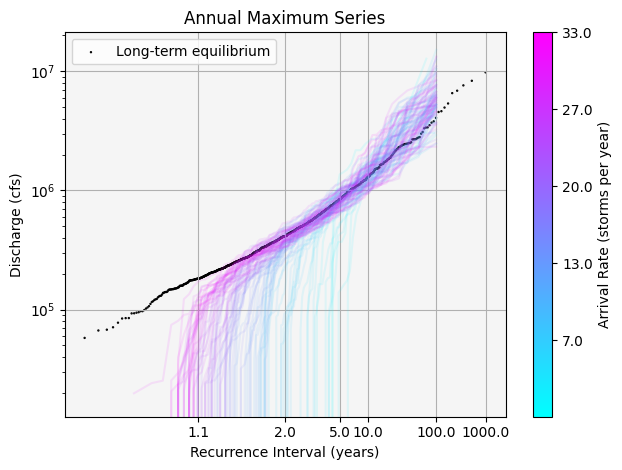

In [82]:
fig, ax = plt.subplots()
ax.scatter(z_lt, q_sort, ec='k', fc='none', s=0.5, label="Long-term equilibrium")

normalizer = mcolors.Normalize(vmin=1, vmax=1000)
cmap = cm.cool
for storm_count in range(30, 1000, 10):
    i = run_simulation(storm_count, p_obs, observed_record_length, 100, 1)[0]
    if len(i) < 2:
        continue
    tmp_q_sort = np.sort(i)[::-1]
    aep = np.array([(i + 1) / (len(tmp_q_sort) + 1) for i in range(len(tmp_q_sort))])
    z = norm.ppf(1 - aep)
    color = cmap(normalizer(storm_count))
    ax.plot(z, tmp_q_sort, c=color,alpha=0.1)
    
sm = cm.ScalarMappable(cmap=cmap, norm=normalizer)
sm.set_array([])  # Only needed for older matplotlib
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Arrival Rate (storms per year)')
cbar.ax.set_yticklabels([f"{round(t/observed_record_length, 0)}" for t in cbar.get_ticks()])

ax.legend()
ris = np.array([1.1, 2, 5, 10, 100, 1000])
aep = 1 / ris
z_ticks = norm.ppf(1 - aep)
ax.set_xticks(z_ticks)
ax.set_xticklabels(ris)
ax.set_xlabel("Recurrence Interval (years)")
ax.set_yscale("log")
ax.set_ylabel("Discharge (cfs)")
ax.set_title("Annual Maximum Series")
ax.set_facecolor("whitesmoke")
plt.grid(True)
plt.tight_layout()